<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Otimiza%C3%A7%C3%A3o_Ag_pol%C3%ADtica_de_manuten%C3%A7%C3%A3o_preventiva_imperfeita_v13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [466]:
%%capture
pip install geneticalgorithm

In [467]:
%%capture
pip install memory-profiler

In [468]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import csv
import math
from geneticalgorithm import geneticalgorithm as ga
from scipy.optimize import differential_evolution
from memory_profiler import profile
import locale

In [469]:
!dpkg-reconfigure locales

Generating locales (this might take a while)...
  en_US.UTF-8... done
  pt_BR.ISO-8859-1... done
Generation complete.


In [470]:
# Install locale pt_BR
!/usr/share/locales/install-language-pack pt_BR

Generating locales (this might take a while)...
Generation complete.
dpkg-trigger: error: must be called from a maintainer script (or with a --by-package option)

Type dpkg-trigger --help for help about this utility.


In [471]:
print(locale.getlocale())

('pt_BR', 'ISO8859-1')


In [472]:
locale.setlocale(locale.LC_ALL, 'pt_BR.iso88591')

'pt_BR.iso88591'

In [473]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [474]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 15000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 600 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 15000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

VALOR_DIMENSOES = int(DIAS_OBSERVADOS / 30)

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_ag/'
NOME_ARQUIVO_PRINCIPAL = 'melhor_custo_ag_primeiro_cenario'
NOME_ARQUIVO_TEMPO_SEVERIDADE = '_tempo_severidade'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO = '01'

In [475]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
          # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break

    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        fileIntensidade = "ut_reducao_idade_linear"
        #

        plt.plot(self.u)
        #
        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')
        #
        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha $\it{u(t)}$")
        plt.show()

In [476]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m

    return fator

In [477]:
# efine a função de melhoria Linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j]*theta)
        fator.append(linha)

    return fator

In [478]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - math.exp(-s[k][j]*theta))
        fator.append(linha)

    return fator

In [479]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j]**theta)
        fator.append(linha)

    return fator

In [480]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [481]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [482]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.2:2000, 0.4: 4000, 0.5: 9000, 0.9: 12000}
    cmp_f = dist[s]
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US
17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US 2.000 e US
3.000, respectivamente e MC fixa em US$15.000 texto em itálico

In [483]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/cenario{CENARIO}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0


* t: Representa os tempos de falha.
* k: Indica o índice do sistema.
* c: Representa o número de ciclos de manutenção.
* n: Indica o número de falhas em cada ciclo de manutenção preventiva.
* s: Representa a severidade das manutenções preventivas em cada sistema.
* T: Indica os tempos das manutenções preventivas.

In [484]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [485]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[0]
    beta = x[1]
    theta = x[2]

    # Cria fator de melhoria
    #fator = pot(ck, m, s, theta)
    fator = execute_function(fator_melhoria, ck, m, s, theta)
    #print(fator)


    #print(theta, a)
    #
    cont = 0
    fitness = 1
    #
    for k in range(0, m, 1):
        for j in range(0, ck, 1):
            prod = 1;
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;
                #print('Prod = ', prod)
        #
        soma = 0
        for l in range(0, ck, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);
            #print('Soma = ', soma)
        #
        #try:
        ans = math.exp(-soma)
        #except OverflowError:
        #    ans = float('inf')
        #
        fitness = fitness * prod * ans;
        #

    return (-1)*fitness

In [486]:
# Ajusta o modelo com base nos dados lidos
def adjust_model():
    global model_adjusted
    model_adjusted = True

    varbound = np.array([[100, 150], [1, 2], [0, 1]])

    algorithm_param = {
        'max_num_iteration': 50,
        'population_size': 100,
        'mutation_probability': 0.05,
        'elit_ratio': 0.01,
        'crossover_probability': 0.75,
        'parents_portion': 0.3,
        'crossover_type': 'two_point',
        'max_iteration_without_improv': None
    }

    model = ga(
        function=objective,
        dimension=3,
        variable_type='real',
        variable_boundaries=varbound,
        algorithm_parameters=algorithm_param,
        convergence_curve=False,
        progress_bar=False
    )

    # Registre o tempo de início de convergência para a primeira etapa
    start_time_first_stage = time.time()

    model.run()


    # Registre o tempo de término
    end_time_first_stage = time.time()

    # Calcule o tempo total de convergência
    convergence_time_first_stage = end_time_first_stage - start_time_first_stage

    res = model.best_variable

    lamb = res[0]
    beta = res[1]
    theta = res[2]

    return lamb, beta, theta, convergence_time_first_stage

In [487]:
# Variáveis Globais
model_adjusted = False

In [488]:
# Ajusta o modelo
lamb, beta, theta, convergence_time_first_stage = adjust_model()
print(f'lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

<ipython-input-485-0257c025fc35>:31: RuntimeWarning: invalid value encountered in double_scalars
  soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);
<ipython-input-485-0257c025fc35>:25: RuntimeWarning: invalid value encountered in double_scalars
  prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);


 The best solution found:
 [114.65387022   1.81089449   0.17941129]

 Objective function:
 nan
lamb: 114.65387021832738
beta: 1.8108944916366307
theta: 0.17941129392996302

Tempo de Convergência para a primeira etapa: 2.8004822731018066 segundos


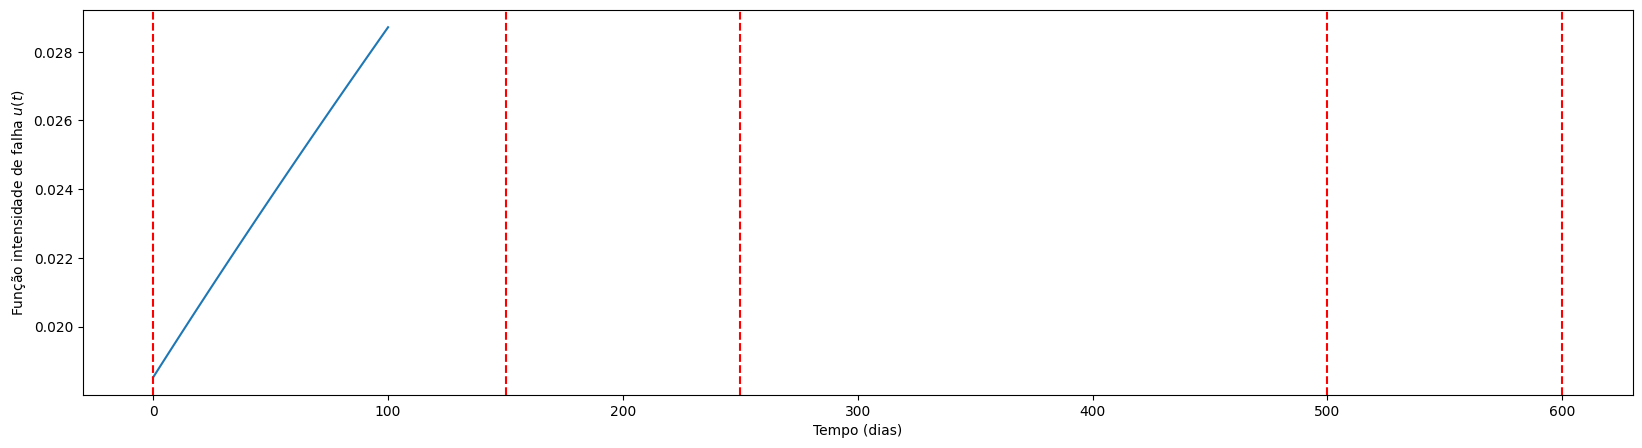

Fator ajuste:  [0.06924995471219308, 0.08579975671351014, 0.14910808215897553, 0.03524612191097831]


In [489]:
# lamb = 149.49576004448562
# beta = 5.051869901420757
# theta = 0.9138502982364278

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

# Etapa 2: Otimização

In [490]:
# Configurar a formatação da moeda
def format_currency(value):
    return locale.currency(value, grouping=True)

In [491]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]

def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1:0.20, 3:0.40, 5:0.50, 7:0.9}

    results = [] # Lista para armazenar os resultados das funções objetivo

    global s
    T = [0]
    s_row = []
    cont = 0

    for number in x:
        modulo = int(number) % 2
        if modulo == 1:
            inteiro = int(number)
            s_row.append(dict_severidades[inteiro])  # Severidade
            frac = number - inteiro  # Tempo
            t = (cont + frac) * 30
            T.append(int(t))
        cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))


    # Custo Total
    custo = np.sum(Ctotal)
    print('Custo = ', custo)

    # Retorne os resultados da função objetivo como um array
    return custo

Aplica AG para determinar tempos e severidades



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 45, 103, 140, 199, 297, 321, 350, 525, 552, 589]
Severidade para cada subsistema: [0.9, 0.9, 0.9, 0.4, 0.5, 0.2, 0.9, 0.5, 0.9, 0.4]
Número de Sisemas: 5
Fator:  [0.03524612191097831, 0.14910808215897553, 0.14910808215897553, 0.14910808215897553, 0.06924995471219308, 0.08579975671351014, 0.03524612191097831, 0.14910808215897553, 0.08579975671351014, 0.14910808215897553, 0.06924995471219308]
Media de falhas:  [0, 0.18384750775749614, 0.8123134916585208, 1.360844147156108, 2.509808922166205, 5.115905457236773, 5.916819839969754, 6.93737199341691, 14.92843148455416, 16.244548136247772, 18.245592037691562, 18.82528670710365]
Custo =  7605.754840693759


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 18, 96, 261, 275, 374, 394, 427, 511, 546, 571]
Severidade para cada subsistema: [0.9, 0.2, 0.2, 0.9, 0.5, 0.5, 0.4, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.03524612191097831, 0

<ipython-input-491-ed75a77f718a>:81: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 17, 143, 174, 195, 250, 379, 505, 523]
Severidade para cada subsistema: [0.9, 0.2, 0.4, 0.4, 0.2, 0.9, 0.4, 0.4]
Número de Sisemas: 5
Fator:  [0.03524612191097831, 0.14910808215897553, 0.03524612191097831, 0.06924995471219308, 0.06924995471219308, 0.03524612191097831, 0.14910808215897553, 0.06924995471219308, 0.06924995471219308]
Media de falhas:  [0, 0.03154114726979709, 1.4826199725557612, 2.048713534467515, 2.5233019689422704, 3.936213724650591, 8.341636801981746, 14.13643574287135, 14.980440335818908, 19.15816683806367]
Custo =  5394.687967033889


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 21, 118, 132, 193, 230, 283, 320, 418, 481]
Severidade para cada subsistema: [0.9, 0.9, 0.5, 0.2, 0.5, 0.9, 0.4, 0.4, 0.9]
Número de Sisemas: 5
Fator:  [0.03524612191097831, 0.14910808215897553, 0.14910808215897553, 0.08579975671351014, 0.03524612191097831, 0.08579975671351014, 0.1491

/usr/local/lib/python3.10/dist-packages/geneticalgorithm/geneticalgorithm.py:353: RuntimeWarning: invalid value encountered in subtract
  normobj=maxnorm-normobj+1


A saída de streaming foi truncada nas últimas 5000 linhas.
Tempos para manutenções preventivas: [0, 61, 312, 360]
Severidade para cada subsistema: [0.2, 0.2, 0.5]
Número de Sisemas: 5
Fator:  [0.03524612191097831, 0.03524612191097831, 0.03524612191097831, 0.08579975671351014]
Media de falhas:  [0, 0.31893947588249516, 6.071757272832589, 7.836226068852157, 19.661163700665114]
Custo =  1978.4317456994852


Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 61, 249, 471]
Severidade para cada subsistema: [0.2, 0.4, 0.5]
Número de Sisemas: 5
Fator:  [0.03524612191097831, 0.03524612191097831, 0.06924995471219308, 0.08579975671351014]
Media de falhas:  [0, 0.31893947588249516, 4.029731860379056, 12.699058829578465, 19.453182482867778]
Custo =  1910.001615083319


Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 61]
Severidade para cada subsistema: [0.2]
Número de Sisemas: 5
Fator:  [0.03524612191097831, 0.03524612191097831]
Media de falhas

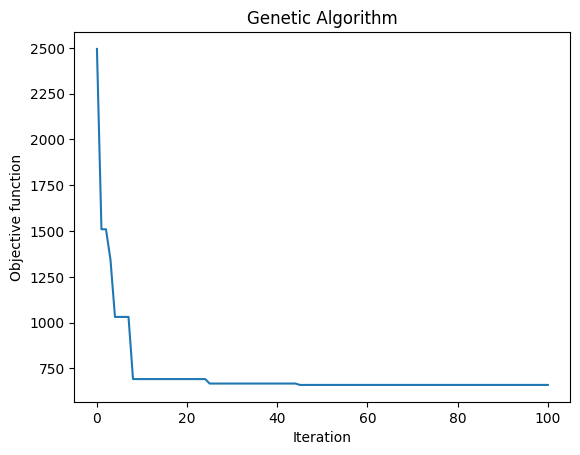

In [492]:
# Otimização da política de manutenção com AG
dimension = VALOR_DIMENSOES
varbound = np.array([[0, 8]] * VALOR_DIMENSOES)

algorithm_param_ = {
    'max_num_iteration': 100,\
    'population_size': 100,\
    'mutation_probability': 0.05,\
    'elit_ratio': 0.01,\
    'crossover_probability': 0.75,\
    'parents_portion': 0.3,\
    'crossover_type': 'two_point',\
    'max_iteration_without_improv': None
}

model_=ga(
    function = objective_st,
    dimension = dimension,
    variable_type = 'real',
    variable_boundaries = varbound,
    algorithm_parameters = algorithm_param_
)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

model_.run()

# Registre o tempo de término
end_time_second_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

In [493]:
# Coletar as melhores posições
best_positions = np.array(model_.output_dict['variable'])

In [494]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 114.65387021832738
beta: 1.8108944916366307
theta: 0.17941129392996302
Tempo de Convergência para a primeira etapa: 2.8004822731018066 segundos


In [495]:
melhorCusto = format_currency(model_.output_dict['function'])
print(melhorCusto)

R$ 660,32


In [496]:
cust = format_currency(313.86950679428423)
print(cust)

R$ 313,87


In [497]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

In [498]:
# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(linha[1])
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

melhores_custos_anteriores.append(melhorCusto)

# Criar uma lista com os valores atuais
valores_atuais = [len(melhores_custos_anteriores), melhorCusto, lamb, beta, theta, convergence_time_first_stage, convergence_time_second_stage,]

# Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Se o arquivo estiver vazio, escreva o cabeçalho
    if arquivo_csv.tell() == 0:
        writer.writerow(['Index', 'Melhor_Custo', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa', 'Ciclos_MP'])

    # Escrever os valores atuais
    writer.writerow(valores_atuais)

In [499]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo, sep=",")
resultado.head(20)

,Index,Melhor_Custo,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
0,1,"R$ 249,22",125.244269,1.989799,0.045221,1.417979,65.728934,NaN
1,2,"R$ 256,86",123.964775,1.989913,0.175622,1.742080,90.076306,NaN
2,3,"-R$ 11.557,84",124.155413,1.957926,0.172091,1.680634,93.496817,NaN
3,4,"-R$ 11.533,65",123.199070,1.985149,0.257185,1.547213,92.437886,NaN
4,5,"-R$ 11.519,24",120.291780,1.988386,0.426772,1.662376,96.029173,NaN
5,6,"R$ 95,20",121.289460,1.149743,0.164003,3.069770,83.978296,NaN
6,7,"R$ 275,65",108.970990,1.898802,0.204521,3.963579,86.979786,NaN
7,8,"-R$ 10.568,25",125.172421,1.916139,0.340700,3.703011,81.810566,NaN
8,9,"R$ 313,87",129.736773,1.240385,0.284955,3.834016,87.888182,NaN
9,10,"R$ 343,03",131.242887,1.400556,0.127827,2.801902,89.635183,NaN


In [500]:
resultado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Index                        12 non-null     int64  
 1   Melhor_Custo                 12 non-null     object 
 2   Lambda                       12 non-null     float64
 3   Beta                         12 non-null     float64
 4   Theta                        12 non-null     float64
 5   Convergencia_Primeira_Etapa  12 non-null     float64
 6   Convergencia_Segunda_Etapa   12 non-null     float64
 7   Ciclos_MP                    0 non-null      float64
dtypes: float64(6), int64(1), object(1)
memory usage: 896.0+ bytes


In [501]:
resultado.describe()

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa,Convergencia_Segunda_Etapa,Ciclos_MP
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,0.0
mean,6.500000,122.590467,1.707399,0.277958,2.582292,88.254828,NaN
std,3.605551,6.031256,0.355608,0.236334,0.948187,9.330832,NaN
min,1.000000,108.970990,1.149743,0.045221,1.417979,65.728934,NaN
25%,3.750000,121.040040,1.360513,0.170069,1.676069,85.640224,NaN
50%,6.500000,123.581922,1.907471,0.191966,2.782472,88.761683,NaN
75%,9.250000,125.190383,1.985958,0.298891,3.228080,92.702619,NaN
max,12.000000,131.242887,1.989913,0.957186,3.963579,104.802610,NaN


In [502]:
param_primeira_etapa = ['Lambda', 'Beta', 'Theta']
param_segunda_etapa = ['Ciclos_MP', 'Melhor_Custo']
convergencia = ['Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa']
Melhor_Custo = ['Melhor_Custo']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

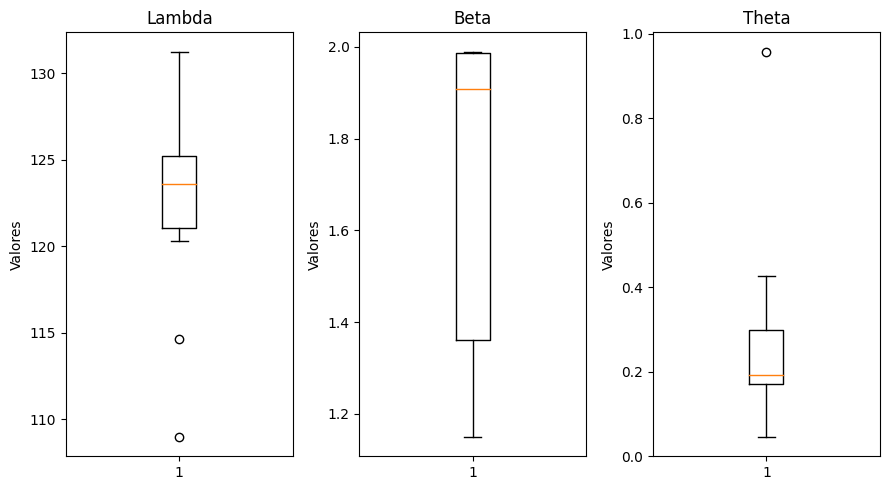

In [503]:
# Cria uma grafico para os parametros Lambda, Beta e Theta
# Tamanho da figura
plt.figure(figsize=(9, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_primeira_etapa):
    plt.subplot(1, 3, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

TypeError: ignored

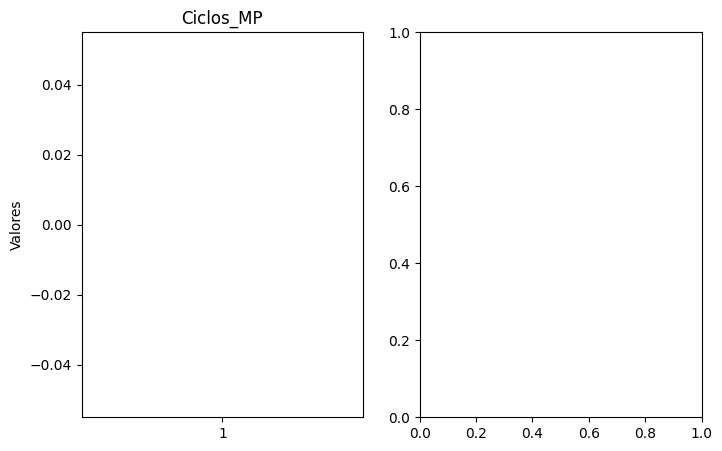

In [504]:
# Cria uma grafico para os parameros da segunda etapa
# Tamanho da figura
plt.figure(figsize=(8, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_segunda_etapa):
    plt.subplot(1, 2, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [ ]:
# Cria uma grafico para comparar as convervencias da primeira e segunda etapa
# Tamanho da figura
plt.figure(figsize=(8, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(convergencia):
    plt.subplot(1, 2, i + 1)  # 1 linhas, 2 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [ ]:
# Seus arrays de tempos e severidade
Tempos = [
    [[137, 259, 380, 536]],
    [[153, 291, 426, 539]],
    [[118, 240, 356, 523]],
    [[199, 360, 526]],
    [[147, 273, 359, 509]],
    [[145, 273, 378, 514]],
    [[195, 354, 518]],
    [[188, 350, 520]],
    [[129, 242, 356, 523]],
    [[125, 237, 390, 534]],
]

severidade = [
    [[1.0, 1.0, 1.0, 0.25]],
    [[1.0, 1.0, 1.0, 0.25]],
    [[1.0, 1.0, 1.0, 0.25]],
    [[1.0, 1.0, 0.25]],
    [[1.0, 1.0, 1.0, 0.25]],
    [[1.0, 1.0, 1.0, 0.25]],
    [[1.0, 1.0, 0.5]],
    [[1.0, 1.0, 0.5]],
    [[1.0, 1.0, 1.0, 0.25]],
    [[1.0, 1.0, 1.0, 0.25]],
]

# Verifique se ambos os arrays têm o mesmo número de linhas
if len(Tempos) == len(severidade):
    with open(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', "w") as file:
        file.write('Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
        for i in range(len(Tempos)):
            row = Tempos[i] + severidade[i]
            row_str = [str(value) for value in row]
            file.write(f"{i};{';'.join(row_str)}\n")
else:
    print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")

In [ ]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', sep=";")
dados.head(10)

In [ ]:
dados.info()

In [ ]:
dados.describe()